# Explore FrameNet 1.7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from collections import defaultdict
import random
import math
import pickle
import nltk
from nltk.corpus import framenet as fn

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Look at some annotated sentences

210k sentences, of which 200k are exemplars and 10k are full text.

Only the exemplars have frame annotations, so we'll only use the exemplars.

In [2]:
print("Exemplars:", len(fn.exemplars()))
print("Full text:", len(fn.ft_sents()))
print("Total:", len(fn.sents()))

Exemplars: 200751
Full text: 10147
Total: 210898


In [3]:
fn_sents = fn.exemplars()

In [4]:
fn_sents[12345]

exemplar sentence (4097054):
[corpID] 135
[docID] 23514
[paragNo] 19
[sentNo] 1
[aPos] 0

[LU] (10677) according to.prep in Attributed_information

[frame] (1148) Attributed_information

[annotationSet] 2 annotation sets

[POS] 24 tags

[POS_tagset] PENN

[GF] 2 relations

[PT] 2 phrases

[text] + [Target] + [FE]

Early 1990s , According to the British Observer , the British 
              ********* ** --------------------   ------------
                           Text                   Proposition 
 
government exported chemicals to Iran that can be used to 
----------------------------------------------------------
                                                          
 
manufacture weapons .
-------------------
                   
 


## Distribution of sentence lengths

Average sentence is about 22 tokens, sharp dropoff at 40 for some reason.

In [5]:
# Much faster than nltk.tokenize.word_tokenize
def approx_len(sent):
  return len(sent.split())

In [6]:
counter = defaultdict(int)
for sent in fn_sents:
  ntok = approx_len(sent.text)
  counter[ntok] += 1

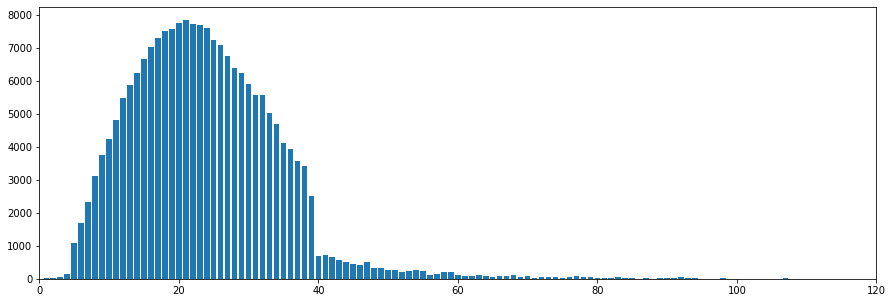

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(counter.keys(), counter.values())
plt.xlim((0, 120))
plt.show()

## Look at some shorter sentences

In [8]:
short_sentences = [sent for sent in fn_sents[:200] if approx_len(sent.text) < 10]

In [9]:
[sent.text for sent in short_sentences]

['Another vehicle was abandoned at Great Victoria Street .',
 ', High Holborn , had been left behind .',
 'Then he left her and went to bed .',
 'Do n\'t forget the binocs . "',
 "It 's crawling with cops . ",
 'Harry looked round the crowded room . ',
 'Occasionally in High Season Nidri Quay becomes crowded . ',
 'Oh it looks crowded . ',
 'The temple is always crowded with worshippers .',
 'The Great Barrier Reef swarms with life . ',
 'The narrow streets swarmed with young people . ',
 'Above them , Hunters swarmed in increasing numbers . ']

In [10]:
len([sent for sent in fn_sents if approx_len(sent.text) <= 10])

16425

## Get sentences of a specific frame

Here, there are 336 sentences labelled with the "Commerce_buy" frame.

In [11]:
buying_frame = fn.frames("Commerce_buy")[0]

In [12]:
buying_frame

frame (171): Commerce_buy

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Commerce_buy.xml

[definition]
  These are words describing a basic commercial transaction
  involving a Buyer and a Seller exchanging Money and Goods, taking
  the perspective of the Buyer.  The words vary individually in the
  patterns of frame element realization they allow.  For example,
  the typical pattern for the verb BUY: Buyer buys Goods from
  Seller for Money. '' 'Abby bought a car from Robin for $5,000.'

[semTypes] 0 semantic types

[frameRelations] 7 frame relations
  <Parent=Commerce_buy -- Inheritance -> Child=Renting>
  <Parent=Getting -- Inheritance -> Child=Commerce_buy>
  <Parent=Commerce_buy -- Using -> Child=Importing>
  <Parent=Commerce_buy -- Using -> Child=Shopping>
  <Source=Commerce_buy -- ReFraming_Mapping -> Target=Renting>
  <Source=Commerce_scenario -- ReFraming_Mapping -> Target=Commerce_buy>
  <Neutral=Commerce_goods-transfer -- Perspective_on -> Perspectivized=Co

In [13]:
len(fn.exemplars(frame="Commerce_buy"))

336

## Get all frame elements of sentences

Easy to extract spans for frame elements, but they can be whole phrases, proper nouns, pronouns, etc.

Target seems to always be one word, in the set of words that lexically trigger the frame.

In [14]:
example_sent = fn.exemplars(frame="Commerce_buy")[0]
example_text = example_sent.text

In [15]:
example_sent

exemplar sentence (812690):
[sentNo] 0
[aPos] 24789176

[LU] (2966) buy.v in Commerce_buy

[frame] (171) Commerce_buy

[annotationSet] 2 annotation sets

[POS] 18 tags

[POS_tagset] BNC

[GF] 4 relations

[PT] 4 phrases

[Sent] 1 entry

[text] + [Target] + [FE]

Four years ago I bought an old Harmony Sovereign acoustic guitar 
               - ****** ---------------------------------------- 
               B        Goods                                    
 
for £20 from an absolute prat . 
------- ---------------------
Money   Seller               
 (B=Buyer)


In [16]:
print(example_sent.Target)
print(example_sent.FE[0])

[(17, 23)]
[(15, 16, 'Buyer'), (24, 64, 'Goods'), (65, 72, 'Money'), (73, 94, 'Seller')]


In [17]:
print("Target:", example_text[example_sent.Target[0][0]:example_sent.Target[0][1]])

Target: bought


In [18]:
for span_start, span_end, fe_name in example_sent.FE[0]:
  print(f"{fe_name}: '{example_text[span_start:span_end]}'")

Buyer: 'I'
Goods: 'an old Harmony Sovereign acoustic guitar'
Money: 'for £20'
Seller: 'from an absolute prat'


## Most popular frames

About 1k unique frames, most popular frame is Self_motion, with 6.4k sentences (3% of total).

In [19]:
frame_count = defaultdict(int)
for sent in fn_sents:
  frame_count[sent.frame.name] += 1

In [20]:
for frame_name, count in sorted(frame_count.items(), key=lambda kv: kv[1], reverse=True)[:15]:
  print(frame_name, count)

Self_motion 6454
Stimulus_focus 4058
Emotion_directed 3391
Clothing 3187
Statement 3060
Body_parts 2678
Natural_features 2374
Containers 2118
Experiencer_obj 2072
Judgment_communication 1990
Food 1744
Leadership 1631
Experiencer_focus 1500
Building_subparts 1467
Aggregate 1455


In [21]:
len(frame_count)

1014

## Look at frame-to-frame relations

In [59]:
def frame_parents(frame_name):
  frame = fn.frames(frame_name)[0]
  ret = []
  for rel in frame.frameRelations:
    if rel.get("Parent") is not None and rel.Child.name == frame_name:
      ret.append(rel.Parent.name)
  return ret

Commerce_buy frame inherits from Getting, and has 7 direct frame-to-frame relations.

This can be explored interactively: https://framenet.icsi.berkeley.edu/fndrupal/FrameGrapher.

Also has FE relations, eg, Getting.Recipient = Commerce_buy.Buyer.

In [67]:
frame_parents("Commerce_buy")

['Getting']

In [83]:
list(fn.frames("Commerce_buy")[0].frameRelations)

[<Parent=Commerce_buy -- Inheritance -> Child=Renting>,
 <Parent=Getting -- Inheritance -> Child=Commerce_buy>,
 <Parent=Commerce_buy -- Using -> Child=Importing>,
 <Parent=Commerce_buy -- Using -> Child=Shopping>,
 <Source=Commerce_buy -- ReFraming_Mapping -> Target=Renting>,
 <Source=Commerce_scenario -- ReFraming_Mapping -> Target=Commerce_buy>,
 <Neutral=Commerce_goods-transfer -- Perspective_on -> Perspectivized=Commerce_buy>]

In [81]:
list(fn.frames("Commerce_buy")[0].frameRelations[1].feRelations)

[<Parent=Getting.Manner -- Inheritance -> Child=Commerce_buy.Manner>,
 <Parent=Getting.Means -- Inheritance -> Child=Commerce_buy.Means>,
 <Parent=Getting.Place -- Inheritance -> Child=Commerce_buy.Place>,
 <Parent=Getting.Purpose -- Inheritance -> Child=Commerce_buy.Purpose>,
 <Parent=Getting.Explanation -- Inheritance -> Child=Commerce_buy.Explanation>,
 <Parent=Getting.Time -- Inheritance -> Child=Commerce_buy.Time>,
 <Parent=Getting.Source -- Inheritance -> Child=Commerce_buy.Seller>,
 <Parent=Getting.Theme -- Inheritance -> Child=Commerce_buy.Goods>,
 <Parent=Getting.Recipient -- Inheritance -> Child=Commerce_buy.Buyer>]